In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
from sklearn.datasets import fetch_openml

In [5]:
mnist = fetch_openml('mnist_784',version = 1)

In [6]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X,y = mnist["data"], mnist["target"]

In [8]:
X.shape

(70000, 784)

In [9]:
y.shape

(70000,)

In [10]:
some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

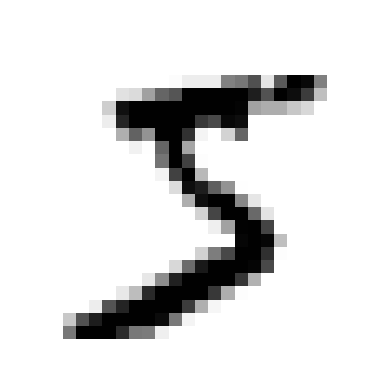

In [11]:
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")

In [12]:
y[0]

'5'

In [13]:
y = y.astype(np.uint8)

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000], y[60000:]

In [15]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [16]:
from sklearn.linear_model import SGDClassifier

In [17]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

**# Implementing the cross validation**

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [19]:
skfolds = StratifiedKFold(n_splits = 3)

In [20]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.iloc[train_index]
  y_train_folds = y_train_5.iloc[train_index]
  X_test_fold = X_train.iloc[test_index]
  y_test_fold = y_train_5.iloc[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [22]:
from sklearn.base import BaseEstimator

In [23]:
class Never5Classifier(BaseEstimator):
  def fit(self,X,y = None):
    pass
  def predict(self,X):
    return np.zeros((len(X),1),dtype = bool)

In [24]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

# Confusion Matrix

In [25]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

# For our "5-detector" model, the matrix has four key numbers:

True Positives (TP): Correctly predicted 5s. The model said "5" and the image was indeed a "5". (In the example, this is 3,530.)

False Positives (FP): Incorrectly predicted 5s. The model said "5" but the image was actually a different number. This is also known as a "Type I error." (In the example, this is 687.)

True Negatives (TN): Correctly predicted non-5s. The model said "not a 5" and the image was indeed not a "5". (In the example, this is 53,892.)

False Negatives (FN): Incorrectly predicted non-5s. The model said "not a 5" but the image was actually a "5". This is also known as a "Type II error." (In the example, this is 1,891.)

A perfect classifier would have a confusion matrix with only true positives and true negatives, meaning all the numbers would be on the main diagonal.

# Pretending We reached to perfection

In [27]:
y_train_perfect_predictions = y_train_5 # pretend that we reached to perfections so that y_perfect = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**Precision and Recall**
<br>
Scikit-Learn provides several functions to compute classifier metrics,
including precision and recall:

In [28]:
from sklearn.metrics import precision_score, recall_score

In [29]:
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [30]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

It is often convenient to **combine precision and recall into a single metric**
called the **F1 score**, in particular if you need a simple way to compare two
classifiers. The **F1 score** is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the
harmonic mean gives much more weight to low values. As a result, the
classifier will only get a high **F1 score** if both recall and precision are high.


In [31]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343847

In [32]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

Scikit-Learn does not let you set the threshold directly, but it does give
you access to the decision scores that it uses to make predictions. Instead
of calling the classifier‚Äôs predict() method, you can call its
decision_function() method, which returns a score for each instance,
and then use any threshold you want to make predictions based on those
scores:


In [33]:
threshold = 0 # set threshold value to 0
y_some_digit_pred = (y_scores > threshold) # check if the value is greater than the threshold
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code
returns the same result as the predict() method (i.e., True). Let‚Äôs raise
the threshold:


In [34]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred


array([False])

# How to decide the threshold value
1.Get the *cross_val_predict* using the decision method to get the scores of all the instances in the training set

2.Next call *precision_recall_curve* to compute the precision and recall for all the possible thresholds:

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method ="decision_function" )

In [36]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

Finally, use Matplotlib to plot precision and recall as functions of the
threshold value

Finally, use Matplotlib to plot precision and recall as functions of the threshold value

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.legend()



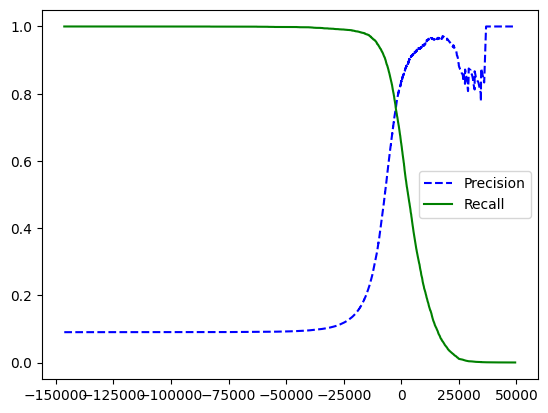

In [38]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


## So, another way to implement the precision/recall trade-off is to plot the precision vs recall graph

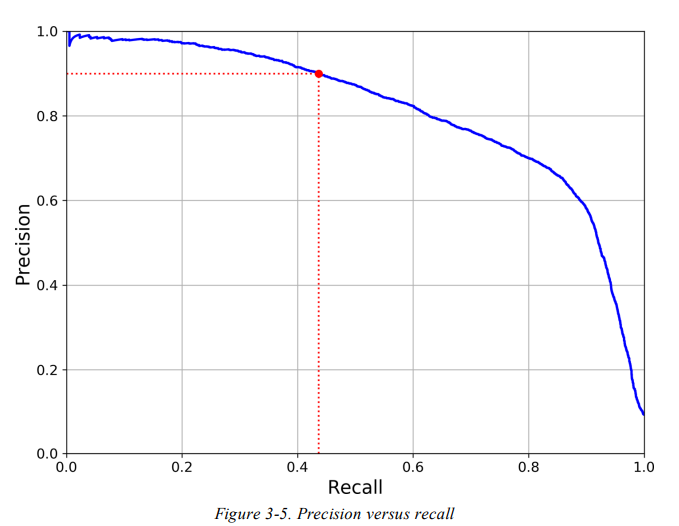



Here the precision falls after 80% of recall value

Now, suppose we aim for 90% precision...
So, we would find the lowest threshold value to get the 90% of precision



In [39]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

np.float64(3370.0194991439557)

# If you have still confusion then this is the easiest explanation:
Recall ‚Üí looks at the actual dataset (ground truth).
üëâ ‚ÄúOut of all the real 5s, how many did I correctly catch?‚Äù

Precision ‚Üí looks at the model‚Äôs predictions.
üëâ ‚ÄúOut of all the times I predicted 5, how many were actually 5s?‚Äù

‚úÖ Example:
Suppose in the dataset there are 100 actual 5s.

Model predicted 49 as 5 ‚Üí out of those, 44 are correct (true 5s), 5 are wrong.

So precision = 44 / 49 ‚âà 90%.

Recall = 44 / 100 = 44%.

In [40]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [41]:
## Let's check this predictions

In [42]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [43]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [44]:
from sklearn.metrics import roc_curve

In [45]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

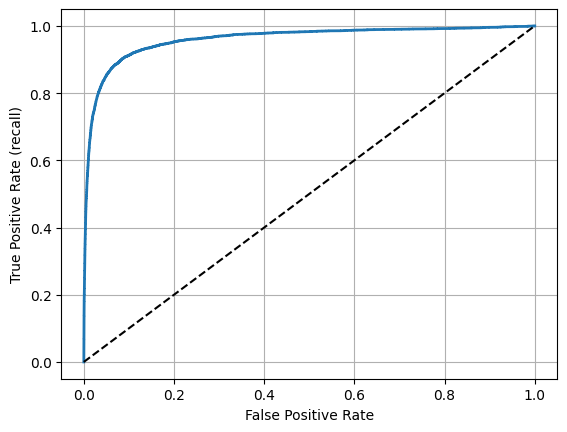

In [46]:
def plot_roc_curve(fpr,tpr,label = None):
  plt.plot(fpr,tpr,linewidth = 2,label = label)
  plt.plot([0,1],[0,1],'k--') #Dashed Diagonal
  plt.grid(True)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate (recall)')

plot_roc_curve(fpr,tpr)


In [47]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)


np.float64(0.9604938554008616)

## Here the roc_auc_score is 96% that is an Excellent model!!

# Now training a RandomForestClassifier

In [48]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

In [49]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [50]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest =roc_curve(y_train_5,y_scores_forest)


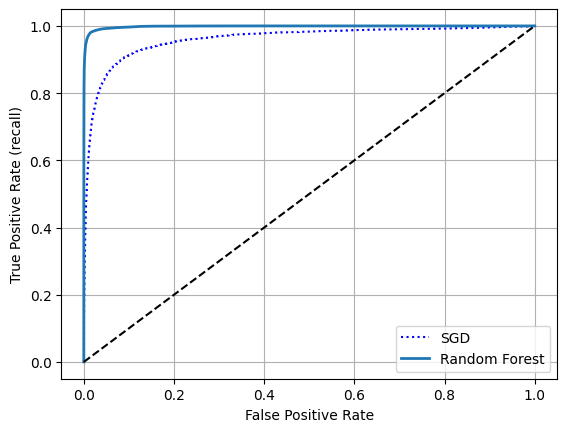

In [51]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()


# Multiclass Classification

In [52]:
from sklearn.svm import SVC

In [53]:
svm_clf = SVC()

In [54]:
svm_clf.fit(X_train,y_train)  # y_train, not y_train_5
svm_clf.predict([some_digit])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [55]:
some_digit_scores = svm_clf.decision_function([some_digit])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [56]:
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [57]:
np.argmax(some_digit_scores)

np.int64(5)

In [58]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [59]:
svm_clf.classes_[5]

np.uint8(5)

In [60]:
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train,cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx


array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

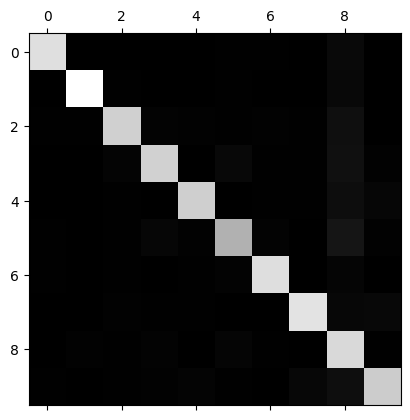

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

# Multilabel classification

#  Tagging Digits
 Instead of predicting what number an image shows (e.g., "7"), it tries to predict two different things about it at once:
 Is the digit "large"? (i.e., is it a 7, 8, or 9?)

Is the digit "odd"? (i.e., is it a 1, 3, 5, 7, or 9?)

So, for each image, the model has to produce two labels.

Let's look at the digit 5:

Is it large (>= 7)? No (False).

Is it odd? Yes (True).
So, the correct "multilabel" for the digit 5 is [False, True].

Let's look at the digit 9:

Is it large (>= 7)? Yes (True).

Is it odd? Yes (True).
So, the correct "multilabel" for the digit 9 is [True, True].

The code trains a classifier (KNeighborsClassifier) to look at an image of a digit and output this pair of [True/False, True/False] answers.

This code creates a y_multilabel array containing two target labels for
each digit image: the first indicates whether or not the digit is large (7, 8,
or 9), and the second indicates whether or not it is odd. The next lines
create a KNeighborsClassifier instance (which supports multilabel
classification, though not all classifiers do), and we train it using the
multiple targets array. Now you can make a prediction, and notice that it
outputs two labels:


In [64]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [65]:
knn_clf.predict([some_digit])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [66]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel,cv=3)

## How Do You Measure Performance? üìà
Since the model gives multiple answers for each item, how do you know if it's doing a good job?

The text explains a simple and common method: calculate a score for each label separately and then average them.

Imagine the model is a student taking a two-part test: a **"Is it Large?"** quiz and an **"Is it Odd?"** quiz.

First, you grade the **"Is it Large?"** quiz and give it a score (like an F1 score). Let's say it gets 98%.

Then, you grade the **"Is it Odd?"** quiz and give it a score. Let's say it gets 96%.

Finally, you just average the two scores: (98 + 96) / 2 = 97%. This gives you an overall performance measure.

This is what `average="macro"` does‚Äîit treats each label (or quiz) as equally important.

The `average="weighted"` option is slightly different. It gives more importance to the labels that show up more often in the data. If, for example, there were way more odd numbers than large numbers in your dataset, the score from the "Is it Odd?" quiz would have a bigger impact on the final average.

In [67]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

# Multioutput Classification

## What is Multioutput Classification? üé®
Think of it as an advanced version of the multilabel classification we just discussed.

Multilabel (the movie genres): You answer several Yes/No questions for one item. Is it "Action"? Yes/No. Is it "Comedy"? Yes/No.

Multioutput: You answer several multiple-choice questions for one item.

Imagine you're describing a car. You don't just give it one label. You have to fill out a form with multiple fields:

Color: (Red, Blue, Black, White, Silver)

Body Type: (Sedan, SUV, Hatchback)

Number of Doors: (2, 4)

A single car's output would be a combination of these, like `[Color: Blue, Body Type: SUV, Doors: 4]`. That's a multioutput prediction. Each label (Color, Body Type) can have more than two possible values.

The Image Denoising Example Explained
The text uses a cool example: cleaning up a noisy image of a digit.

The Goal: Take a messy, static-filled image of a number and make it clean again.

Here‚Äôs how it works as a multioutput problem:

The "Multiple Outputs": An MNIST image is made of 784 pixels (a 28x28 grid). Think of the final, clean image as having 784 different labels you need to predict‚Äîone label for each pixel.

The "Multiple Classes": Each label (each pixel) isn't just a Yes/No answer. It can be any grayscale value from 0 (completely black) to 255 (completely white). So, each of the 784 labels has 256 possible values (or classes).

So, the model's job is to look at the noisy image and, for every single one of the 784 pixels, decide what its new grayscale value should be. It's making 784 separate multiple-choice predictions at once!

In [68]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [73]:
# This is what the plot_digit() function likely contains
def plot_digit(image_data):
    # Reshape the flat array of 784 pixels into a 28x28 grid
    image = image_data.reshape(28, 28)

    # Use imshow() to display the grid as an image
    # cmap="binary" makes it a black-and-white grayscale image
    plt.imshow(image, cmap="binary")

    # Hide the numbered axes to make it look cleaner
    plt.axis("off")

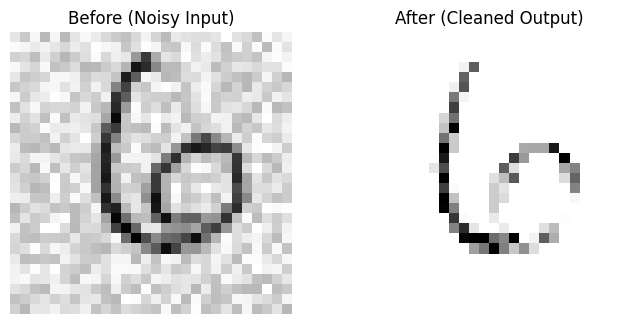

In [83]:
knn_clf.fit(X_train_mod, y_train_mod)
some_index = [100] # You can change this number to see a different digit

# 2. Get the noisy image and its cleaned version
noisy_digit = X_test_mod.iloc[some_index]
clean_digit = knn_clf.predict(noisy_digit) # Use the model to predict the clean version

# 3. Set up the plot to be side-by-side
plt.figure(figsize=(8, 4))

# Plot the noisy image on the left
plt.subplot(1, 2, 1)
plt.title("Before (Noisy Input)")
plot_digit(noisy_digit.values) # Assuming you have the plot_digit helper function

# Plot the cleaned image on the right
plt.subplot(1, 2, 2)
plt.title("After (Cleaned Output)")
plot_digit(clean_digit)

# 4. Show the final plot
plt.show()